In [28]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [29]:
class TripletDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        """
        :param image_folder: объект torchvision.datasets.ImageFolder
        :param transform: преобразования для изображений
        """
        self.image_folder = image_folder
        self.transform = transform
        self.class_to_indices = self._group_by_class()

    def _group_by_class(self):
        """
        Создает словарь, где ключ — класс, а значение — индексы изображений этого класса.
        """
        class_to_indices = {}
        for idx, (path, label) in enumerate(self.image_folder.samples):
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(idx)
        return class_to_indices

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        # Берем базовое изображение (Anchor)
        anchor_path, anchor_label = self.image_folder.samples[idx]
        anchor = Image.open(anchor_path).convert("RGB")

        # Позитивное изображение из того же класса
        positive_idx = random.choice(self.class_to_indices[anchor_label])
        positive_path, _ = self.image_folder.samples[positive_idx]
        positive = Image.open(positive_path).convert("RGB")

        # Негативное изображение из другого класса
        negative_labels = list(self.class_to_indices.keys())
        negative_labels.remove(anchor_label)  # Убираем текущий класс
        negative_label = random.choice(negative_labels)
        negative_idx = random.choice(self.class_to_indices[negative_label])
        negative_path, _ = self.image_folder.samples[negative_idx]
        negative = Image.open(negative_path).convert("RGB")

        # Применяем трансформации, если они есть
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative


In [30]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip '/content/drive/MyDrive/Archive.zip'

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = ImageFolder(root="dogs")
test_dataset = ImageFolder(root="test_200_database")

In [32]:
train_triplet_dataset = TripletDataset(image_folder=train_dataset, transform=transform)
train_dataloader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

test_triplet_dataset = TripletDataset(image_folder=test_dataset, transform=transform)
test_dataloader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

In [33]:
model = models.resnet50(weights='IMAGENET1K_V1')
model = torch.nn.Sequential(*list(model.children())[:-1])

for param in model.parameters():
    param.requires_grad = False

# Разморозим только последний блок ResNet — `layer4`
for layer in list(model.children())[7:]:
    for param in layer.parameters():
        param.requires_grad = True

for name, param in model.named_parameters():
    print(name, param.requires_grad)

0.weight False
1.weight False
1.bias False
4.0.conv1.weight False
4.0.bn1.weight False
4.0.bn1.bias False
4.0.conv2.weight False
4.0.bn2.weight False
4.0.bn2.bias False
4.0.conv3.weight False
4.0.bn3.weight False
4.0.bn3.bias False
4.0.downsample.0.weight False
4.0.downsample.1.weight False
4.0.downsample.1.bias False
4.1.conv1.weight False
4.1.bn1.weight False
4.1.bn1.bias False
4.1.conv2.weight False
4.1.bn2.weight False
4.1.bn2.bias False
4.1.conv3.weight False
4.1.bn3.weight False
4.1.bn3.bias False
4.2.conv1.weight False
4.2.bn1.weight False
4.2.bn1.bias False
4.2.conv2.weight False
4.2.bn2.weight False
4.2.bn2.bias False
4.2.conv3.weight False
4.2.bn3.weight False
4.2.bn3.bias False
5.0.conv1.weight False
5.0.bn1.weight False
5.0.bn1.bias False
5.0.conv2.weight False
5.0.bn2.weight False
5.0.bn2.bias False
5.0.conv3.weight False
5.0.bn3.weight False
5.0.bn3.bias False
5.0.downsample.0.weight False
5.0.downsample.1.weight False
5.0.downsample.1.bias False
5.1.conv1.weight False
5.

In [34]:
class AverageMeters(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [35]:
def accuracy(anchor_embed, positive_embed, negative_embed):
    with torch.no_grad():
        d_ap = F.pairwise_distance(anchor_embed, positive_embed)  # Anchor-Positive
        d_an = F.pairwise_distance(anchor_embed, negative_embed)  # Anchor-Negative
        correct = (d_ap < d_an).sum().item()
        accuracy = correct / anchor_embed.size(0) * 100  # процент точных предсказаний
    return accuracy

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
plt.show()

cuda


In [37]:
def train_loop(dataloader, model, criterion, optimizer):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to train mode
    model.train()

    for _, (anchor, positive, negative) in enumerate(dataloader):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # compute output
        anchor_embed = model(anchor).view(anchor.size(0), -1)
        positive_embed = model(positive).view(positive.size(0), -1)
        negative_embed = model(negative).view(negative.size(0), -1)

        loss = criterion(anchor_embed, positive_embed, negative_embed)

        # measure accurasy
        acc = accuracy(anchor_embed, positive_embed, negative_embed)

        # record loss and accurasy
        losses.update(loss.item(), anchor_embed.size(0))
        accs.update(acc, anchor_embed.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return accs.avg, losses.avg

In [38]:
def test_loop(dataloader, model, criterion):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to val mode
    model.eval()

    for _, (anchor, positive, negative) in enumerate(dataloader):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # compute output
        anchor_embed = model(anchor).view(anchor.size(0), -1)
        positive_embed = model(positive).view(positive.size(0), -1)
        negative_embed = model(negative).view(negative.size(0), -1)

        loss = criterion(anchor_embed, positive_embed, negative_embed)

        # measure accurasy
        acc = accuracy(anchor_embed, positive_embed, negative_embed)
        
        # record loss and accurasy
        losses.update(loss.item(), anchor_embed.size(0))
        accs.update(acc, anchor_embed.size(0))

    return accs.avg, losses.avg

In [39]:
def save_checkpoint(save_path, state, epoch, tag=''):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, "{}checkpoint-{:06}.pth.tar".format(tag, epoch))
    torch.save(state, filename)

In [40]:
config = {
    "batch_size": 32,
    "learning_rate": 1e-6,
    "total_epochs": 40,
    "save_epoch": 5,
    "save_path": "./weights"
}

In [41]:
random_seed = 42

In [42]:
criterion = nn.TripletMarginLoss(margin=1, p=2)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

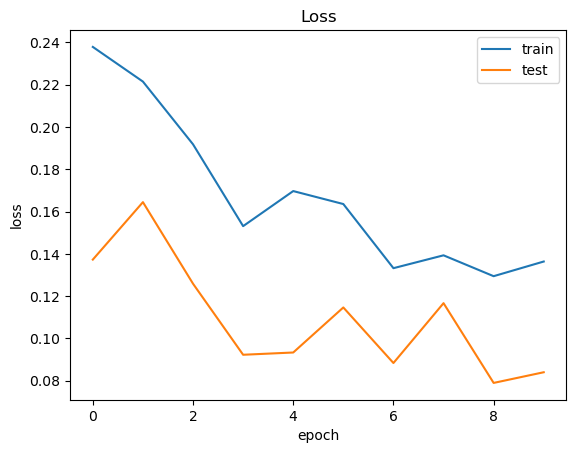

[9/40]		 LR: Train acc: 94.6	 Train loss: 0.136	 Test acc: 96.9	 Test loss: 0.084
Current LR: 1e-06


In [ ]:
print("Start train")
log = {"epoch": [], "train_acc": [], "train_loss": [], "test_acc": [], "test_loss": []}

for epoch in range(config["total_epochs"]):
    train_acc, train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_acc, test_loss = test_loop(test_dataloader, model, criterion)
    scheduler.step(test_loss)

    if epoch % config["save_epoch"] == 0:
        state = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "loss": test_loss,
            "acc": test_acc,
            "optimizer": optimizer.state_dict(),
            "criterion": criterion.state_dict(),
        }
        save_checkpoint(config["save_path"], state, epoch, '')


    log["epoch"].append(epoch)
    log["train_loss"].append(train_loss)
    log["test_loss"].append(test_loss)

    clear_output(wait=True)

    plt.plot(log["epoch"], log["train_loss"], label="train")
    plt.plot(log["epoch"], log["test_loss"], label="test")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.show()

    line = "[{}/{}]\t\t LR: Train acc: {:.3}\t Train loss: {:.3}\t Test acc: {:.3}\t Test loss: {:.3}".format(
        epoch,
        config["total_epochs"],
        train_acc,
        train_loss,
        test_acc,
        test_loss
    )

    print(line)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr}")

print("Stop train")
